In [1131]:
import pandas as pd
import numpy as np

import time
import string
import random

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymorphy2

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import FastICA, PCA

import xgboost as xgb

In [974]:
FIG_SIZE = (15, 6)

IS_PROTOTYPING = True
PROTOTYPE_SIZE = 1000

In [1081]:
#убираем ретвит и RT, так же убираем \n
def replace_answer(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and x != 'RT', msg.split()))

#нормализуем и преобразуем хештег в слово (опционально)
morph = pymorphy2.MorphAnalyzer()
def normal_form(word, remove_hashtag = False):
    if remove_hashtag and word.startswith('#'):
        word = word[1:]
        
    return morph.parse(word)[0].normal_form

#почему-то нет некоторых знаков пунктуации и части стоп-слов
custom_stops = [u'...', u'ещё', u'это', u'весь', u'..', u'—', u'я', u'и', u'a', u'\u2026']
stop = set(stopwords.words('russian') + list(string.punctuation) + custom_stops + list(string.digits))
def remove_stop_words(words):
    return [w for w in words if w not in stop]

USE_NORMAL_FORM = True
tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return tknzr.tokenize(msg)

In [1152]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

# оставляем только класс и сам текст сообщения
# TODO: зависит ли тональность от отправителя? (кто-то склонен к грусти, кто-то к радости)
# Или времени суток/времени года (летом радость, осенью грусть)?
neg = neg.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos['ttext'] = pos['ttext'].apply(replace_answer)
neg['ttext'] = neg['ttext'].apply(replace_answer)

In [1153]:
def test_models(sizes, models, n_gramms_max = 1):
    for n_gramm in range(1, n_gramms_max + 1):
        scores = {m[0]: [] for m in models}

        vectorizer = TfidfVectorizer(min_df  = 3, ngram_range= (1, n_gramm),
                                     stop_words = stop, tokenizer = tweet_tokenize)

        for s in sizes:
            print 'starting process %d tweets' % (s*2)
            X = pd.concat([pos[:s], neg[:s]])

            y = np.array(X['ttype'])
            X_tweets = np.array(X['ttext'])

            for m in models:
                pipe = Pipeline( [('vect', vectorizer), ('model', m[1])])
                cv_score = np.mean(cross_val_score(pipe, X_tweets, y, cv = 5, n_jobs = 5))

                scores[m[0]].append(cv_score) 

        plt.figure(figsize=FIG_SIZE)

        for m in scores:
            print m, scores[m]
            plt.plot(sizes, scores[m], label = m)

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad = 0.)
        plt.title('n-gramms: %d' % n_gramm)
    

starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
starting process 20000 tweets
starting process 40000 tweets
Linear SVC [0.78150000000000008, 0.77699999999999991, 0.79359999999999997, 0.80149999999999988, 0.8136000000000001]
XGB [0.77299999999999991, 0.77750000000000008, 0.78749999999999998, 0.79654999999999998, 0.80280000000000007]
bayes [0.75700000000000001, 0.78075000000000006, 0.80130000000000001, 0.80570000000000008, 0.81784999999999997]
Non-linear SVC [0.74349999999999994, 0.67199999999999993, 0.6583, 0.62905, 0.66739999999999999]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
starting process 20000 tweets
starting process 40000 tweets
Linear SVC [0.78149999999999997, 0.77949999999999997, 0.79109999999999991, 0.80089999999999983, 0.81362500000000004]
XGB [0.77000000000000002, 0.77524999999999999, 0.79100000000000004, 0.79889999999999994, 0.80257500000000004]
bayes [0.75600000000000001, 0.7812500000000

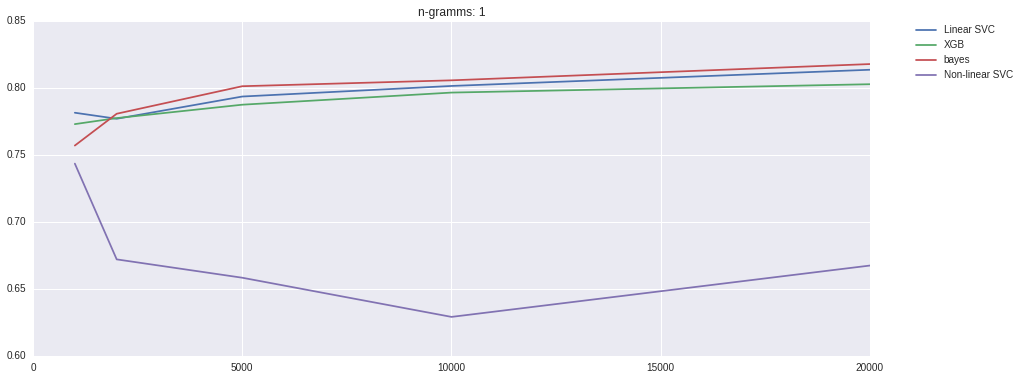

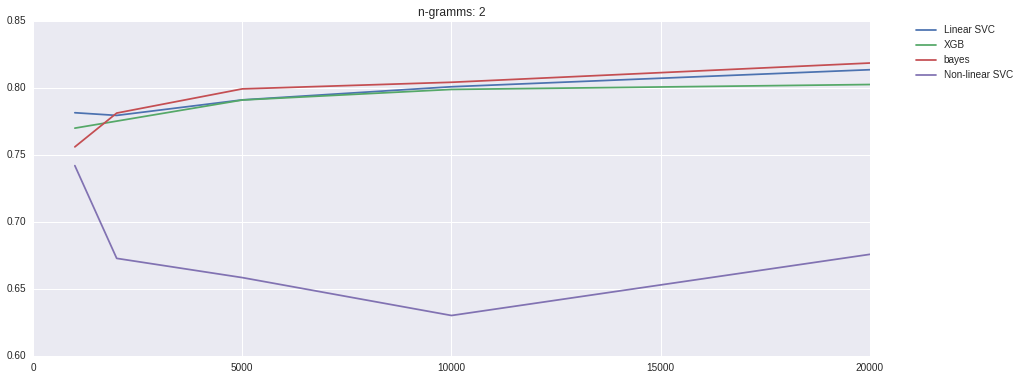

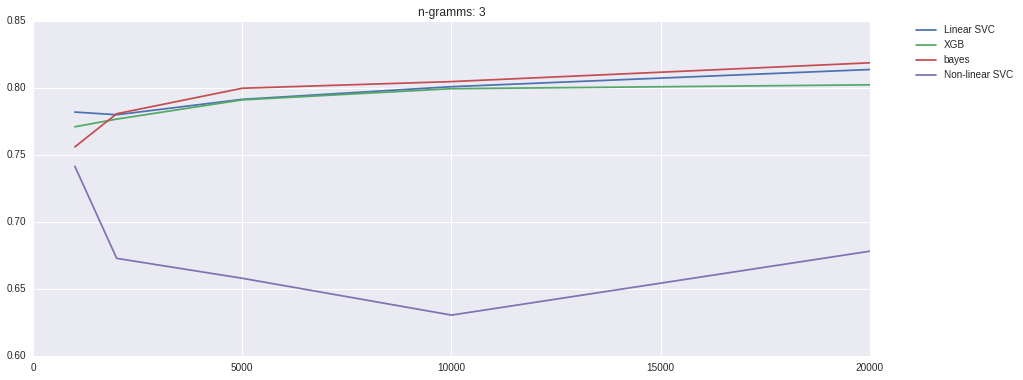

In [1154]:
models_to_test = [
    ('bayes', naive_bayes.MultinomialNB()),
    ('XGB', xgb.XGBClassifier(n_estimators=1000)),
    ('Linear SVC', svm.LinearSVC()),
    ('Non-linear SVC', svm.SVC())
]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 20000]

USE_NORMAL_FORM = False
test_models(sizes_to_test, models_to_test, n_gramms_max = 3)

starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
starting process 20000 tweets
starting process 40000 tweets
Linear SVC [0.75449999999999995, 0.77224999999999999, 0.79630000000000012, 0.80495000000000005, 0.81940000000000013]
XGB [0.77100000000000002, 0.76724999999999999, 0.79249999999999998, 0.80470000000000008, 0.80995000000000006]
bayes [0.77100000000000002, 0.77299999999999991, 0.80090000000000006, 0.81024999999999991, 0.82237499999999986]
Non-linear SVC [0.67599999999999993, 0.66499999999999992, 0.65049999999999997, 0.62204999999999999, 0.59077500000000005]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
starting process 20000 tweets
starting process 40000 tweets
Linear SVC [0.75650000000000006, 0.77100000000000002, 0.79739999999999989, 0.80610000000000004, 0.81634999999999991]
XGB [0.77600000000000002, 0.77224999999999999, 0.79400000000000004, 0.80230000000000001, 0.81167499999999992]
bayes [0.77150000

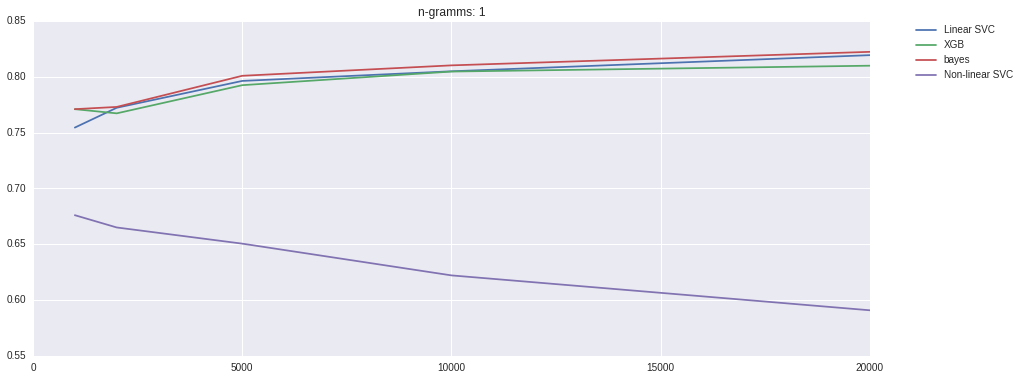

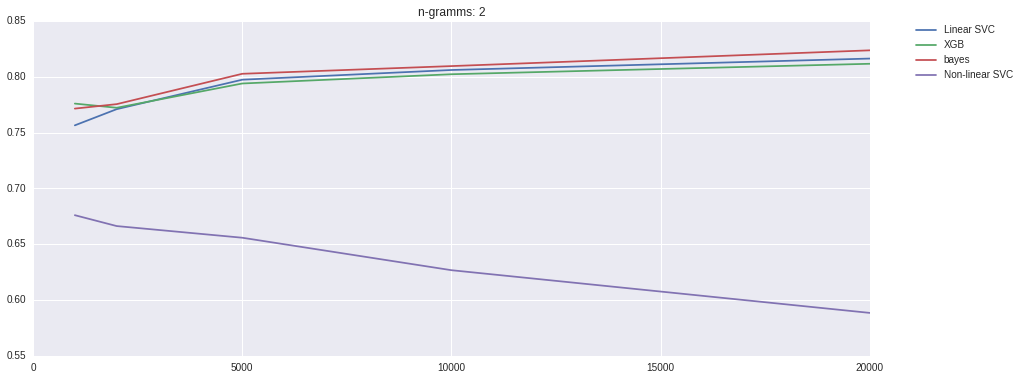

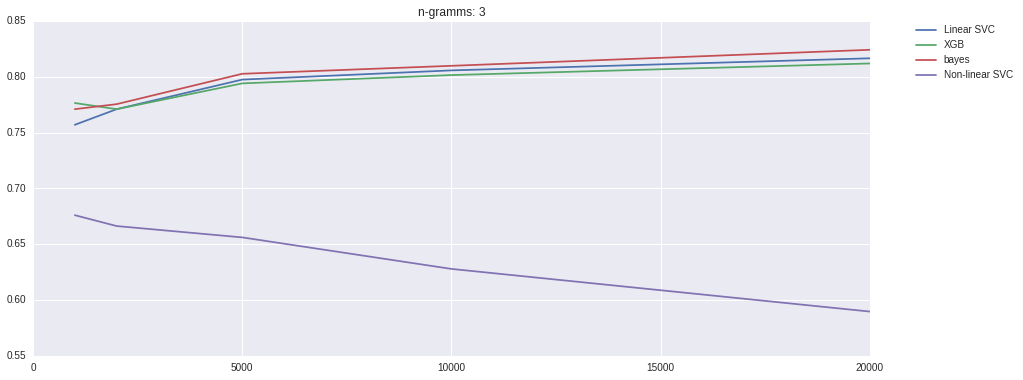

In [1093]:
USE_NORMAL_FORM = True
test_models(sizes_to_test, models_to_test, n_gramms_max=3)

In [1061]:
X_tweets = list(pos['ttext'][:PROTOTYPE_SIZE])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

pos_words = words_counts[-15:]

X_tweets = list(neg['ttext'][:PROTOTYPE_SIZE])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

neg_words = words_counts[-15:]

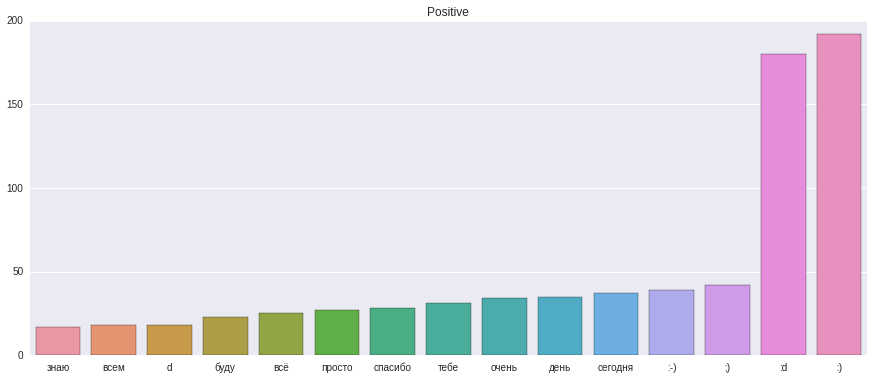

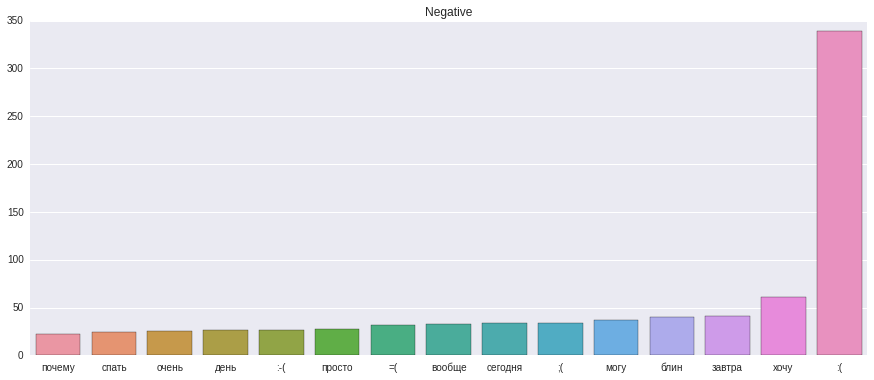

In [1062]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in neg_words], y=[w[1] for w in neg_words])
sns.plt.title('Negative')

In [936]:
from pybrain.datasets import ClassificationDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer, TanhLayer
from pybrain.utilities import percentError

In [903]:
HIDDEN_NEURONS_NUM = 100 
MAX_EPOCHS = 100

In [904]:
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [905]:
ds_train = ClassificationDataSet(X_train_vec.shape[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', X_train_vec)
ds_train.setField('target', y_train[:, np.newaxis]) 
ds_train._convertToOneOfMany( ) 

ds_test = ClassificationDataSet(X_test_vec.shape[1], nb_classes=len(np.unique(y_test)))
ds_test.setField('input', X_test_vec)
ds_test.setField('target',  y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

In [938]:
np.random.seed(0)

for nn in range(100, 1000, 100):
    print 'neurons num: %d' % nn
    net = buildNetwork(ds_train.indim, nn, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass=TanhLayer)

    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)

    trainer = BackpropTrainer(net, dataset = ds_train) 
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs = 10)

    res_train = net.activateOnDataset(ds_train).argmax(axis=1) # Подсчет результата на обучающей выборке
    print 'Error on train: ', percentError(res_train, ds_train['class']), '%' # Подсчет ошибки
    res_test = net.activateOnDataset(ds_test).argmax(axis=1) # Подсчет результата на тестовой выборке
    print 'Error on test: ', percentError(res_test, ds_test['class']), '%' # Подсчет ошибки
    print '********'

neurons num: 100
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 200
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 300
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 400
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 500
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 600
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 700
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 800
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 900
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********


FeedForwardNetwork-152
   Modules:
    [<BiasUnit 'bias'>, <LinearLayer 'in'>, <SigmoidLayer 'hidden0'>, <SoftmaxLayer 'out'>]
   Connections:
    [<FullConnection 'FullConnection-148': 'hidden0' -> 'out'>, <FullConnection 'FullConnection-149': 'in' -> 'hidden0'>, <FullConnection 'FullConnection-150': 'bias' -> 'out'>, <FullConnection 'FullConnection-151': 'bias' -> 'hidden0'>]

